# Multi-Layer Perceptron (MLP) for survival analysis with miRNA/mRNA data

## Notebook Objectives

1. **Data Loading**  
   - Import and perform an initial exploration of preprocessed miRNA/mRNA datasets.

2. **Data Preprocessing**  
   - Remove optional clinical columns.  
   - Standardize numerical features.

3. **Target Preparation**  
   - Convert survival information into a model-compatible format.  
   - Create a signed target variable to distinguish between death events and censored observations.

4. **Data Splitting**  
   - Divide the dataset into training and test sets.  
   - Implement K-fold cross-validation.

5. **Model Definition**  
   - Implement an MLP with 3 and 5 hidden layers.  
   - Use PyTorch and Skorch for model construction and training.

6. **Hyperparameter Optimization**  
   - Perform Grid Search to optimize model parameters.

7. **Model Saving**  
   - Save the best-performing models and their corresponding parameters.

8. **Evaluation and Visualization**  
   - Compute performance metrics (MAE, R²).  
   - Visualize loss curves and compare predicted vs. actual values.


## Init

In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

In [4]:
base = os.path.basename(os.getcwd())
list = os.getcwd().split(os.sep) 
list.pop(list.index(base))
ROOT = '\\'.join(list)
DATA_PATH = os.path.join(ROOT, 'datasets\\preprocessed')

In [5]:
import sys

path_to_networks = os.path.join(ROOT, 'scripts')
sys.path.append(path_to_networks)

from networks import Net_3layers, Net_5layers

In [6]:
# available datasets:
#   miRNA\\clinical_miRNA_normalized_log.csv
#   miRNA\\clinical_miRNA_normalized_quant.csv
#   mRNA\\clinical_mRNA_normalized_log.csv
#   mRNA\\clinical_mRNA_normalized_tpm_log.csv
dataset = pd.read_csv(os.path.join(DATA_PATH, 'miRNA', 'clinical_miRNA_normalized_log.csv'))

# set folder name for saving models: 
#   'miRNA_quant' for quantile normalized data
#   'miRNA_log' for log normalized data
#   'mRNA_log' for mRNA log normalized data
#   'mRNA_tpm_log' for mRNA TPM log normalized data
folder_name = 'miRNA_log'

In [7]:
print(dataset.shape)
print(dataset.columns)

(746, 951)
Index(['days_to_death', 'age_at_initial_pathologic_diagnosis',
       'days_to_last_followup', 'Death', 'pathologic_stage_Stage I',
       'pathologic_stage_Stage IA', 'pathologic_stage_Stage IIA',
       'pathologic_stage_Stage IIB', 'pathologic_stage_Stage IIIA',
       'pathologic_stage_Stage IIIC',
       ...
       'hsa-mir-934', 'hsa-mir-935', 'hsa-mir-937', 'hsa-mir-938',
       'hsa-mir-939', 'hsa-mir-940', 'hsa-mir-942', 'hsa-mir-943',
       'hsa-mir-944', 'hsa-mir-95'],
      dtype='object', length=951)


## Hyper-parameters

In [8]:
num_folds = 5
# Note: don't use too high number (to 20) of folds for small datasets, as the training sets will be very small and BatchNorm1d layer will not work properly.
SEED = 42
WITH_CLINICAL = True  # If False, only miRNA/mRNA data will be used

In [9]:
random.seed(SEED)
np.random.seed(SEED)
_ = torch.manual_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [10]:
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

## Data

In [11]:
y_cols = ['Death', 'days_to_death', 'days_to_last_followup']
X_cols = [col for col in dataset.columns if col not in y_cols]

if not WITH_CLINICAL:
    # remove clinical data columns
    X_cols = [col for col in X_cols if col.startswith('hsa') or col.startswith('gene.')]

custom_dtype = np.dtype([
    ('death', np.bool_),
    ('days', np.float64)
])

y = []
for index,row in dataset[y_cols].iterrows():
    if row['Death'] == 1:
        y.append(np.array((True, row['days_to_death'].item()), dtype=custom_dtype))
    elif row['Death'] == 0:
        y.append(np.array((False, row['days_to_last_followup'].item()), dtype=custom_dtype)) 
y = np.array(y)

X = dataset[X_cols]

In [12]:
death = y['death']
days = y['days']
y_signed = np.where(death, days, -days)

In [13]:
y_signed

array([-1.918e+03, -1.309e+03, -0.000e+00, -2.120e+02,  2.763e+03,
       -1.100e+01, -2.700e+01, -8.450e+02, -1.460e+02, -1.710e+02,
       -1.730e+03, -0.000e+00, -1.172e+03, -1.370e+02, -2.000e+00,
       -1.014e+03, -1.870e+02, -4.390e+02, -1.374e+03, -8.670e+02,
       -2.600e+01, -8.270e+02, -3.100e+01,  4.456e+03, -9.050e+02,
       -2.600e+01, -2.600e+02, -2.680e+02, -6.500e+01, -1.000e+01,
       -1.680e+02, -3.970e+02, -1.148e+03, -5.880e+02, -3.650e+02,
        2.520e+03, -0.000e+00, -2.250e+02, -7.400e+01, -3.230e+02,
       -7.970e+02, -4.300e+01, -1.800e+01, -5.770e+02, -7.480e+02,
       -1.623e+03, -3.400e+01, -3.710e+02, -1.394e+03, -0.000e+00,
       -1.750e+03, -2.730e+02, -2.730e+02, -9.000e+00, -4.630e+02,
       -1.813e+03, -5.180e+02, -3.040e+02, -2.316e+03, -2.740e+02,
       -8.410e+02, -1.780e+02, -1.620e+02, -1.110e+02, -9.720e+02,
       -5.383e+03, -5.180e+02, -7.750e+02, -1.826e+03, -0.000e+00,
        5.380e+02, -3.170e+02,  2.551e+03, -4.260e+02, -2.200e

## Z-scaling

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

scaler = StandardScaler()

cols_leave = [col for col in X.columns if col.startswith('pathologic')]
cols_standardize = [col for col in X.columns if col not in cols_leave]

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

scaled_X = pd.DataFrame(
    x_mapper.fit_transform(X).astype('float32'),
    columns=X.columns,
    index=X.index
)

Note: list for more info about standardization: [Visual Studio Magazine - How to standardize data](https://visualstudiomagazine.com/articles/2014/01/01/how-to-standardize-data-for-neural-networks.aspx)

## Data splitting

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y_signed, test_size=0.2, random_state=SEED)

In [16]:
print("y_train mean/std:", np.mean(y_train), np.std(y_train))
print("y_test mean/std:", np.mean(y_test), np.std(y_test))

y_train mean/std: -511.56208053691273 1106.5066838695645
y_test mean/std: -539.62 1290.5846255089202


## K-fold

In [17]:
from sklearn.model_selection import KFold, StratifiedKFold

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)
#kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# Linear MLP

In [35]:
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import mean_absolute_error, accuracy_score, r2_score, make_scorer, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from skorch import NeuralNetRegressor
from skorch.callbacks import LRScheduler, EarlyStopping
# from lifelines.utils import concordance_index

## Plots and results

In [18]:
def plot_real_vs_predicted(trues, preds, text):
    trues_flat = trues.flatten()
    preds_flat = preds.flatten()
    errors = preds_flat - trues_flat
    
    plt.figure(figsize=(7,7))
    plt.scatter(trues_flat, preds_flat, c=np.abs(errors), cmap='viridis', alpha=0.7)
    plt.plot([trues.min(), trues.max()],
             [trues.min(), trues.max()],
             'r--', label='Perfect prediction')
    plt.colorbar(label="Absolute Error")
    plt.xlabel("Real Days to Death")
    plt.ylabel("Predicted Days to Death")
    plt.title(f"Predicted vs True Days to Death (colored by error) - {text}")
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_losses_grid(model, text):
    plt.figure(figsize=(10, 6))
    plt.plot(model.history[:, 'train_loss'], label='Train Loss')
    plt.plot(model.history[:, 'valid_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss Curves - {text}')
    plt.legend()
    plt.grid()
    plt.show()
    
def plot_losses(train_losses, valid_losses, text=''):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss Curves - {text}')
    plt.legend()
    plt.grid()
    plt.show()

In [30]:
def print_results(preds):
    print("Metric results:")
    
    mae = mean_absolute_error(y_test_mlp, preds)
    mse = mean_squared_error(y_test_mlp, preds)
    r2 = r2_score(y_test_mlp, preds)
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"R²: {r2:.2f}")
    
    print("Preds mean/std:", np.mean(preds), np.std(preds))

## Prepare data for MLP

In [31]:
#y_fixed = np.array([row['days'] for row in y_train], dtype=np.float32)
y_fixed = np.array(y_train, dtype=np.float32)
X_mlp = X_train.values.astype(np.float32)
y_mlp = y_fixed.astype(np.float32)

#y_test_fixed = np.array([row['days'] for row in y_test], dtype=np.float32)
y_test_fixed = np.array(y_test, dtype=np.float32)
y_test_mlp = torch.tensor([row for row in y_test_fixed], dtype=torch.float32)
X_test_mlp = torch.tensor(X_test.values, dtype=torch.float32)

## MLP 3-layers

#### Grid Search for best hyperparameters

In [71]:
X_mlp = X_train.values.astype('float32')
y_mlp = y_train.astype('float32')
X_test_mlp = X_test.values.astype('float32')
y_test_mlp = y_test.astype('float32')

In [72]:
net = NeuralNetRegressor(
    module=Net_3layers,
    module__input_dim=X_mlp.shape[1],
    module__output_dim=1,
    max_epochs=150,
    lr=1e-2,
    batch_size=32,
    optimizer=torch.optim.AdamW,
    optimizer__weight_decay=1e-6,
    criterion=nn.MSELoss(), #nn.MSELoss(),# CoxPHLoss(), # nn.SmoothL1Loss(beta=beta_value), #nn.L1Loss(),
    
    iterator_train__drop_last=True,  # To ensure consistent batch sizes
       
    callbacks=[
         ('lr_scheduler', LRScheduler(
             ReduceLROnPlateau, 
             mode='min', 
             factor=0.7, 
             patience=10, 
             monitor='valid_loss',
             min_lr=1e-6
         )),
        ('early_stopping', EarlyStopping(
             monitor='valid_loss',
             patience=25,
             threshold=1e-3,
             threshold_mode='rel',
             load_best=True
        ))
    ],
)

# For testing purposes, we use a reduced parameter grid
params = {    
    'module__hidden1': [64],
    'module__hidden2': [32],
    'module__dropout': [0.1],
    'lr': [5e-3],
}

In [73]:
rs = GridSearchCV(
    estimator=net,
    param_grid=params,
    refit=True,
    cv=kfold,
    scoring='neg_mean_squared_error',#cindex, 
    verbose=1,
    n_jobs=1
)

rs.fit(X_mlp, y_mlp)

print("Best hyperparameters:", rs.best_params_)
print("Best C-index:", rs.best_score_)

best_model = rs.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1  1651073.4403  1288332.7708  0.0050  0.0952
      2  1648396.3097  1287282.7917  0.0050  0.0757
      3  1644001.3722  1286399.7292  0.0050  0.0861
      4  1637779.1420  1285853.7500  0.0050  0.0754
      5  1630256.7869  1284863.8750  0.0050  0.0754
      6  1623357.3693  1283233.1667  0.0050  0.0788
      7  1614642.0227  1281526.8333  0.0050  0.0734
      8  1604764.3352  1280105.2500  0.0050  0.0747
      9  1595356.4830  1277832.9375  0.0050  0.0717
     10  1582779.8693  1275250.0625  0.0050  0.0763
     11  1573103.1761  1273880.3333  0.0050  0.0674
     12  1557313.6392  1269307.5417  0.0050  0.0705
     13  1542030.4205  1269859.5625  0.0050  0.0742
     14  1525454.6562  1264930.1875  0.0050  0.0729
     15  1511140.0057  1264323.6042  0.0050  0.0735
     16  1491102.5028  1258386.4167  0.0050  0.0717
     

### Save best models 3-layer

In [113]:
os.makedirs(os.path.join(ROOT, f'models/mlp'), exist_ok=True)
os.makedirs(os.path.join(ROOT, f'models/mlp/loss'), exist_ok=True)

folder = folder_name
net_name = "mlp_3" 
if WITH_CLINICAL:
    filename = f'{folder}__{net_name}__clinical.pth'
    path = os.path.join(ROOT, f'models/mlp/{filename}')
    loss_path = os.path.join(ROOT, f'models/mlp/loss/{folder}__{net_name}__clinical_losses.npz')
else:
    filename = f'{folder}__{net_name}__no_clinical.pth'
    path = os.path.join(ROOT, f'models/mlp/{filename}')
    loss_path = os.path.join(ROOT, f'models/mlp/loss/{folder}__{net_name}__no_clinical_losses.npz')
    
torch.save(best_model.module_.state_dict(), path)

train_losses = best_model.history[:, 'train_loss']
valid_losses = best_model.history[:, 'valid_loss']
np.savez(loss_path, train_losses=train_losses, valid_losses=valid_losses)

In [84]:
import json
best_params = rs.best_params_
best_score = rs.best_score_

json_path = os.path.join(ROOT, f'models/mlp/mlp_results.json')
result_dict = {
    filename: {
        "best_parameters": best_params,
        "best_score": best_score
    }
}
with open(json_path, "a") as f:
    json.dump(result_dict, f, indent=4)
    f.write("\n\n") 

'txt_path = f\'../models/mlp_results.txt\'\nwith open(txt_path, \'a\') as f:\n    f.write(f"Model path: {path}\n")\n    f.write(f"Best parameters:\n")\n    for key, value in best_params.items():\n        f.write(f"\t{key}: {value}\n")\n    f.write(f"Best score: {best_score}\n")\n    f.write("=====================================\n")'

### Metrics

In [52]:
preds = best_model.predict(X_test_mlp)
print_results(preds)

Metric results:
MAE: 874.01
MSE: 1679653.12
R²: -0.01
Preds mean/std: -523.10614 336.52023


Metrics for log results:
MAE: 838.38
MSE: 1710816.62
R²: -0.03
Preds mean/std: -309.21146 217.52696


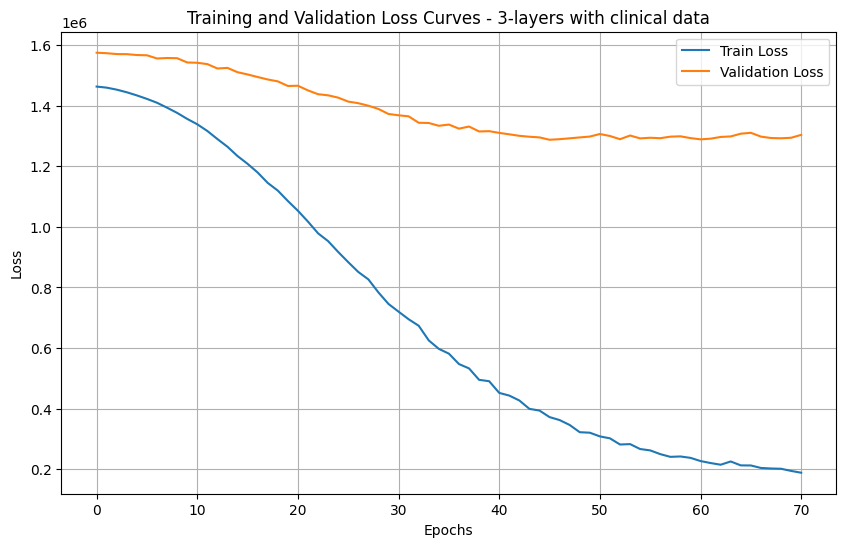

In [94]:
plot_losses_grid(best_model, "3-layers with clinical data" if WITH_CLINICAL else "3-layers without clinical data")

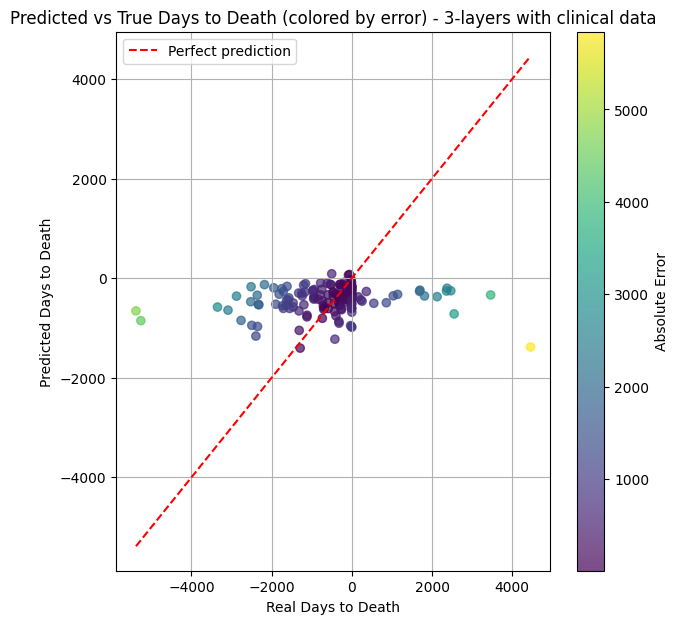

In [48]:
plot_real_vs_predicted(y_test_fixed, preds, "3-layers with clinical data" if WITH_CLINICAL else "3-layers without clinical data")

## MLP 5-layers

In [111]:
net = NeuralNetRegressor(
    module=Net_5layers,
    module__input_dim=X_mlp.shape[1],
    module__output_dim=1,
    max_epochs=100,
    lr=1e-3,
    batch_size=64,
    optimizer=torch.optim.AdamW,
    criterion=nn.MSELoss(),
    #iterator_train__drop_last=True,  # To ensure consistent batch sizes
    callbacks=[
        ('lr_scheduler', LRScheduler(
            ReduceLROnPlateau,
            mode='min',
            factor=0.7,
            patience=10,
            monitor='valid_loss',
            min_lr=1e-6
        )),
        ('early_stopping', EarlyStopping(
            monitor='valid_loss',
            patience=20,
            threshold=1e-4,
            threshold_mode='rel',
            load_best=True
        ))
    ],
)

# For testing purposes, we use a reduced parameter grid
params = {
    'module__dropout': [0.1],
    'lr': [5e-3],
}

In [112]:
rs_5 = GridSearchCV(
    estimator=net,
    param_grid=params,
    refit=True,
    cv=kfold,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=1
)

rs_5.fit(X_mlp, y_mlp.reshape(-1))

print("Best hyperparameters:", rs_5.best_params_)
print("Best C-index:", rs_5.best_score_)

best_model_5 = rs_5.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1  1672767.5447  1289090.7083  0.0050  0.0672
      2  1670754.5711  1288053.1250  0.0050  0.0598
      3  1666045.2211  1285025.9167  0.0050  0.0568
      4  1658560.1408  1282617.3750  0.0050  0.0561
      5  1647646.1763  1278097.5417  0.0050  0.0726
      6  1634508.1658  1282607.1250  0.0050  0.0749
      7  1617752.5276  1279283.8333  0.0050  0.0778
      8  1594283.8171  1276838.5833  0.0050  0.0693
      9  1563638.5592  1278175.8333  0.0050  0.0644
     10  1529140.4559  1269130.9167  0.0050  0.0636
     11  1488245.5743  1268006.7500  0.0050  0.0615
     12  1436367.5914  1254623.3750  0.0050  0.0609
     13  1377663.4118  1241513.4167  0.0050  0.0647
     14  1307003.2743  1245796.2917  0.0050  0.0652
     15  1237240.2211  1227585.6667  0.0050  0.0599
     16  1160337.8230  1222766.1667  0.0050  0.0589
     

### Metrics

In [113]:
preds = best_model_5.predict(X_test_mlp)
print_results(preds)

Metric results:
MAE: 874.65
MSE: 1688382.75
R²: -0.01
Preds mean/std: -512.93677 387.9895


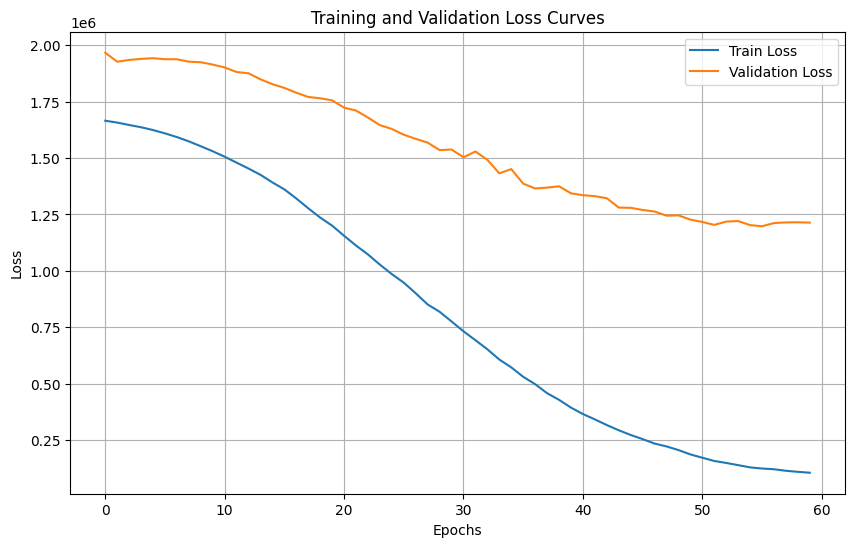

In [52]:
plot_losses_grid(best_model_5, "5-layers with clinical data" if WITH_CLINICAL else "5-layers without clinical data")

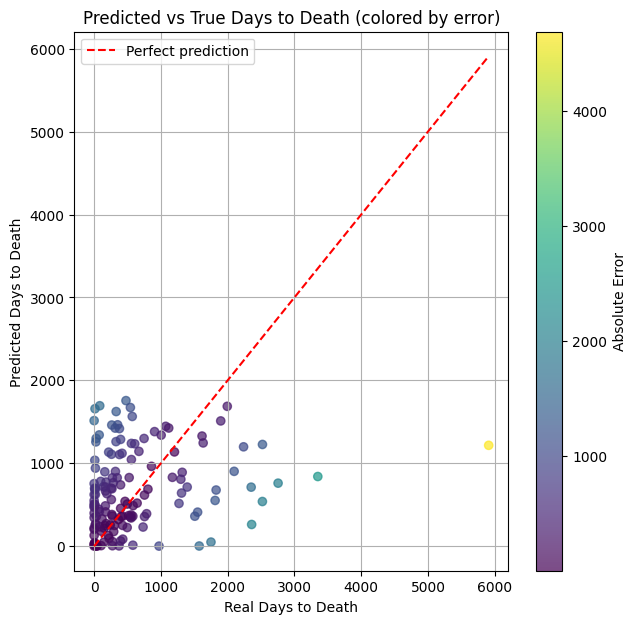

In [55]:
plot_real_vs_predicted(y_test_fixed, preds, "5-layers with clinical data" if WITH_CLINICAL else "5-layers without clinical data")

## Evaluating models saved

### Extract models and parameters from saved files

In [20]:
import json
JSON_PATH = os.path.join(ROOT, 'models', 'mlp', 'mlp_results.json')

with open(JSON_PATH, 'r') as f:
    models_json = json.load(f)

### Load and evaluate specific model

In [21]:
model_filename = 'miRNA_log__mlp_3__clinical.pth'  # Change this to load different models

model_path = os.path.join(ROOT, 'models', 'mlp', model_filename)
params = models_json[model_filename]['best_parameters']
print("Evaluating model:", model_path)
print("Best parameters:", params)

Evaluating model: d:\Universita\2 anno magistrale\Progetto BioInf\miRNA_to_age\models\mlp\miRNA_log__mlp_3__clinical.pth
Best parameters: {'batch_size': 64, 'lr': 0.01, 'module__dropout': 0.7, 'module__hidden1': 64, 'module__hidden2': 32}


In [23]:
import torch

if '3' in model_path:
    model = Net_3layers(
        input_dim=X_train.shape[1],
        output_dim=1,
        hidden1=int(params['module__hidden1']),
        hidden2=int(params['module__hidden2']),
        dropout=float(params['module__dropout'])
    )
else:
    model = Net_5layers(
        input_dim=X_train.shape[1],
        output_dim=1,
        hidden1=int(params['module__hidden1']),
        hidden2=int(params['module__hidden2']),
        hidden3=int(params['module__hidden3']),
        hidden4=int(params['module__hidden4']),
        dropout=float(params['module__dropout'])
    )

# load weights from saved .pth file
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

model.eval()

Net_3layers(
  (model): Sequential(
    (0): Linear(in_features=948, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.7, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.7, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [32]:
X_test_tensor = X_test_mlp.detach().clone().float()

model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
y_pred

tensor([-665.1701, -541.4419, -507.1971, -369.3179, -470.7745, -908.0983,
        -349.0271, -359.8575, -903.5154, -674.3195, -871.1450, -308.2676,
        -275.5222, -468.8296, -292.8518, -534.8146, -407.7825, -354.9611,
        -344.8114, -423.1989, -733.4995, -539.0801, -299.7498, -508.7129,
        -201.5215, -399.5020, -593.6918, -515.9454, -476.7088, -454.1373,
        -322.0357, -761.2496, -266.1256, -341.9853, -535.6357, -527.2922,
        -519.6669, -459.3973, -460.5606, -415.0427, -568.0342, -643.9814,
        -369.5558, -675.7955, -479.5489, -509.6753, -420.1740, -381.2270,
        -379.0078, -278.3431, -145.8433, -382.8246, -889.8033, -266.8573,
        -217.2125, -154.1164, -316.3683, -410.1409, -330.9330, -489.2210,
        -494.4538, -431.6081, -397.9082, -657.7140, -597.6447, -618.5789,
        -429.3890, -670.3986, -612.5245, -183.5493, -369.6464, -315.4163,
        -274.2301, -495.5508, -444.8207, -368.3579, -659.6126, -428.7320,
        -236.4743, -423.6231, -731.790

### Metrics for loaded model

In [36]:
preds_np = y_pred.detach().cpu().numpy()
print_results(preds_np)

Metric results:
MAE: 853.89
MSE: 1640586.25
R²: 0.02
Preds mean/std: -458.61844 166.63252


### Plot real vs predicted values

Attention: remember to reload the right y_test_fixed if you run this cell separately!

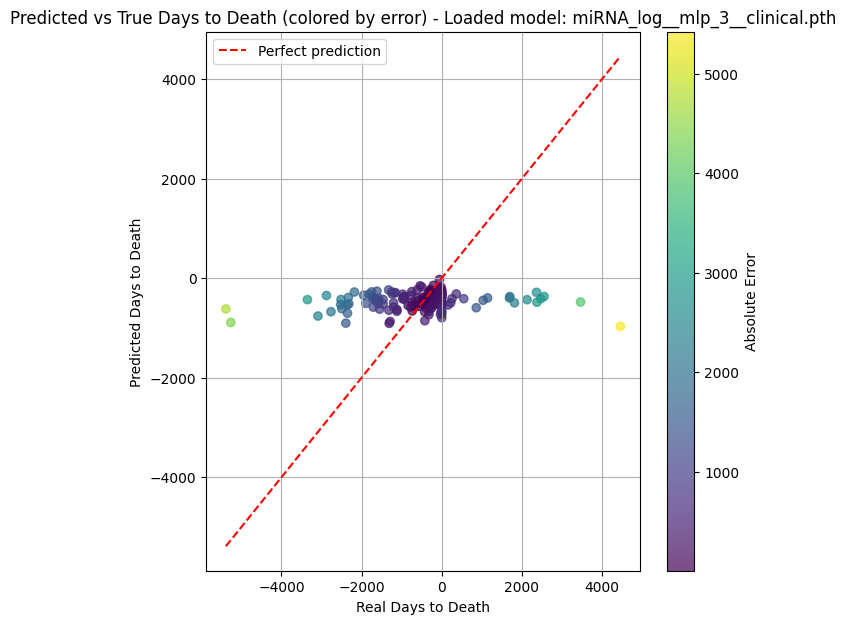

In [37]:
plot_real_vs_predicted(y_test_fixed, preds_np, f"Loaded model: {os.path.basename(model_path)}")

### Plot losses from saved files

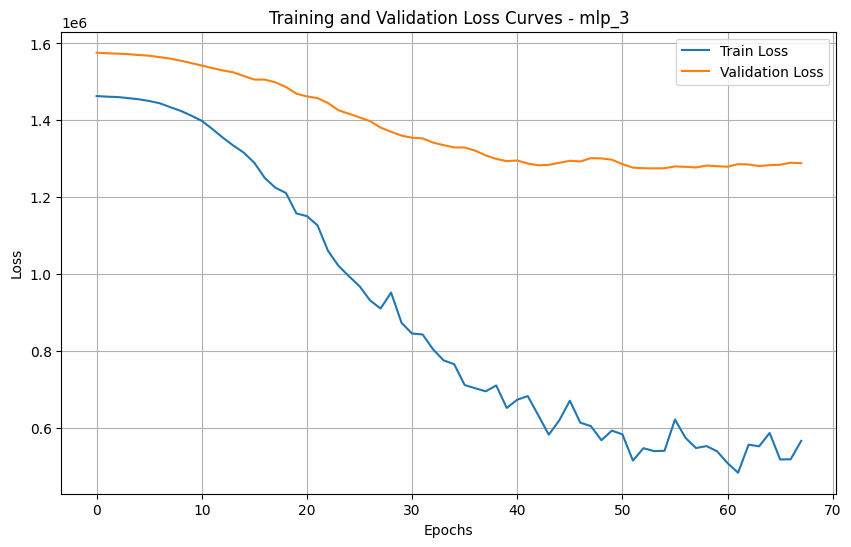

In [38]:
# remove '.npz' extension
file_name = os.path.basename(model_path).replace('.pth', '')

losses = np.load(ROOT + f'/models/mlp/loss/' + f'{file_name}_losses.npz')
train_losses = losses['train_losses']
valid_losses = losses['valid_losses']
plot_losses(train_losses, valid_losses, text='mlp_3')

In [ ]:
models = os.path.join(ROOT, 'models\\mlp')
models = os.listdir(models)
models.remove('loss')
models.remove('mlp_results.json')
print(models)

couples = {}
for m in models:
    if m not in couples.keys() and m not in couples.values():
        base = '__'.join(m.split('__')[:2])
        for j in models:
            if j != m and '__'.join(j.split('__')[:2]) == base:
                couples.append(m:j)



['miRNA_log__mlp_3__clinical.pth', 'miRNA_log__mlp_3__no_clinical.pth', 'miRNA_log__mlp_5__clinical.pth', 'miRNA_log__mlp_5__no_clinical.pth', 'miRNA_quant__mlp_3__clinical.pth', 'miRNA_quant__mlp_3__no_clinical.pth', 'miRNA_quant__mlp_5__clinical.pth', 'miRNA_quant__mlp_5__no_clinical.pth', 'mRNA_log__mlp_3__clinical.pth', 'mRNA_log__mlp_3__no_clinical.pth', 'mRNA_log__mlp_5__clinical.pth', 'mRNA_log__mlp_5__no_clinical.pth', 'mRNA_tpm_log__mlp_3__clinical.pth', 'mRNA_tpm_log__mlp_3__no_clinical.pth', 'mRNA_tpm_log__mlp_5__clinical.pth', 'mRNA_tpm_log__mlp_5__no_clinical.pth']


TypeError: list indices must be integers or slices, not str